# Sentence Pairs -

To detect whether two given sentences are **contradictory** or **non - contradictory**.
### Data Set - 
The dataset contains 4500 labeled rows having 2 sentences and their respective label in each row. 

---

Tags - Python, NLP, Text Classification

### Importing the important libraries

In [1]:
# Linear Algebra and Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
df = pd.read_csv('./data/dataset.txt', header = None, sep = "\t").drop(3, axis = 1)

### Exploratory Data Analysis

In [3]:
# Renaming the columns
df.columns = ['id', 'statement_1', 'statement_2', 'label']

In [4]:
# Checking the value counts
df.label.value_counts()

NEUTRAL          2536
ENTAILMENT       1299
CONTRADICTION     665
Name: label, dtype: int64

In [5]:
# Overview of data
df.head()

,id,statement_1,statement_2,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,NEUTRAL


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           4500 non-null   int64 
 1   statement_1  4500 non-null   object
 2   statement_2  4500 non-null   object
 3   label        4500 non-null   object
dtypes: int64(1), object(3)
memory usage: 140.8+ KB


In [7]:
def label_encoding(df):
    """
    This function will rename the data to be contradiction and non-contradiction and
    then encode the labels into binary.
    param df: data containing 3 columns.
    """
    # Changing the labels 'neutral' and 'entailment' to 'non-contradiction'
    df.loc[(df.label == 'NEUTRAL') | (df.label == 'ENTAILMENT'), 'label'] = 'NON-CONTRADICTION'
    
    # Dropping the ID column
    df.drop('id', axis=1, inplace=True)

    # Changing labels to 0 / 1
    df.loc[(df.label == 'NON-CONTRADICTION'), 'label'] = 0
    df.loc[(df.label == 'CONTRADICTION'), 'label'] = 1
    
    return df

In [8]:
df_labeled = label_encoding(df)

In [9]:
print('Total Number of Statements: {}'.format(len(df)))
print('Contradiction pairs: {}%'.format(round(df['label'].mean() * 100, 2)))

# Finding the total, unique and repeated number of statements
total_statements = pd.Series(df['statement_1'].tolist() + df['statement_2'].tolist())
unique_statements = len(np.unique(total_statements))
repeated_statements = np.sum(total_statements.value_counts() > 1)

print('Total number of unique statements: {}'.format(unique_statements))
print('Number of statements appearing more than once: {}'.format(repeated_statements))
print('Max number of times a single statement is repeated: {}'.format(max(total_statements.value_counts())))

Total Number of Statements: 4500
Contradiction pairs: 14.78%
Total number of unique statements: 4802
Number of statements appearing more than once: 2445
Max number of times a single statement is repeated: 31


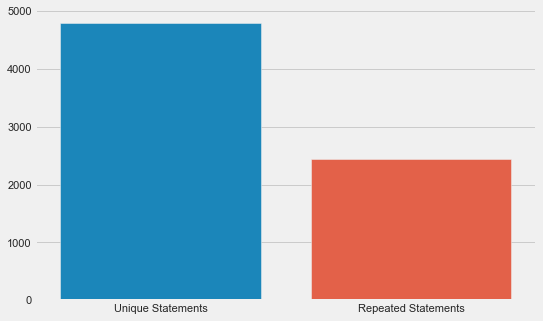

In [10]:
sns.barplot(x = ["Unique Statements", "Repeated Statements"], y = [unique_statements, repeated_statements]);

In [11]:
total_statements = pd.DataFrame({'statements': total_statements})
total_statements['num_of_words'] = total_statements['statements'].apply(lambda x: len(str(x).split()))
total_statements.head()

,statements,num_of_words
0,A group of kids is playing in a yard and an ol...,18
1,A group of children is playing in the house an...,18
2,The young boys are playing outdoors and the ma...,12
3,The kids are playing outdoors near a man with ...,11
4,The young boys are playing outdoors and the ma...,12


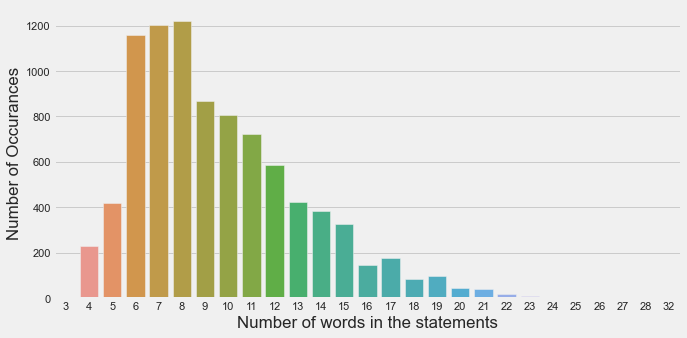

In [12]:
count_words = total_statements.num_of_words.value_counts()
plt.figure(figsize = (10, 5))
sns.barplot(count_words.index, count_words.values)
plt.ylabel('Number of Occurances')
plt.xlabel('Number of words in the statements')
plt.show()

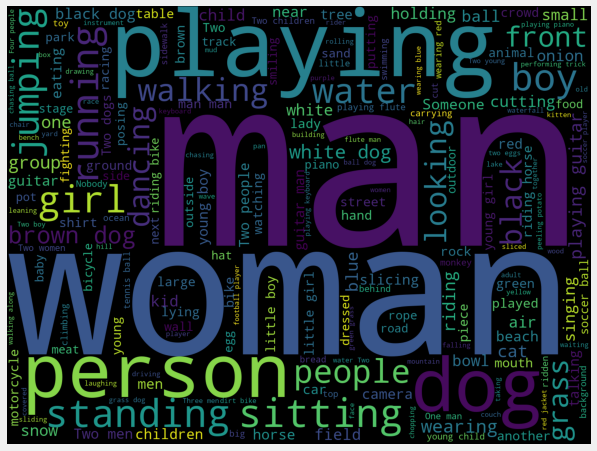

In [13]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(total_statements['statements'].astype(str)))
plt.figure(figsize=(10, 7.5))
plt.imshow(cloud)
plt.axis('off');

# Feature Extraction
We will use word2vec model to make infromative vectors before fitting our dataset into the model.

In [14]:
# import Natural Language Toolkit
import nltk
# Import stop words list
from nltk.corpus import stopwords
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer
# Import Lemmatizer
from nltk.stem import WordNetLemmatizer
# Import Stemmer
from nltk.stem.porter import PorterStemmer
# Import Gensim to use word2vec
import gensim
# Import regex, string
import re, string
from bs4 import BeautifulSoup

In [15]:
df_labeled.head(10)

,statement_1,statement_2,label
0,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,0
1,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,0
2,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,0
3,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,0
4,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,0
5,Two dogs are fighting,Two dogs are wrestling and hugging,0
6,A brown dog is attacking another animal in fro...,Two dogs are fighting,0
7,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,0
8,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,0
9,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,0


In [16]:
def clean_text(df_column):
    """
    This function will clean the text data to fit it
    in the word2vec model. 
    param df_column: Pandas Series model that contain the text data
    """
    clean = []
    
    for doc in df_column:
        x = doc.lower()                     #lowert he case
        x = BeautifulSoup(x, 'lxml').text   #html tag removal
        x = re.sub('[^A-Za-z0-9]+', ' ', x) #separate words by space
        clean.append(x)
    return clean

In [17]:
df_clean = df_labeled.copy()

# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_clean[['statement_1', 'statement_2']], df_clean['label'], 
                                                    test_size=.2, random_state=123, stratify=df_clean['label'])


X_train['statement_1'] = clean_text(X_train['statement_1'])
X_train['statement_2'] = clean_text(X_train['statement_2'])
X_train.head()

,statement_1,statement_2
4486,the military officer is shouting at the recruits,a rollerblader is performing a trick on a ramp
1692,the man is riding a horse by a creek,the man is riding a horse by a stream
2122,a boy is playing a guitar,a boy is not playing a guitar
2974,a woman is wearing a blue helmet and is riding...,the bicyclist is speeding on a city street
4361,a bicyclist is performing a trick over a clean...,a cyclist is performing a jump on a bicycle


In [18]:
sentences = list(X_train.statement_1)
sentences.append(list(X_train.statement_2))
words_in_doc = []
sentences.pop()
print(len(sentences))
for sentence in sentences:
    temp = sentence.split()
    words_in_doc.append(temp)

3600


In [38]:
#Word2vec implementation
model = gensim.models.Word2Vec(words_in_doc,
                              min_count=10, 
                              workers=4,
                              size=200,
                              window=5,
                              iter = 10,
                              sg=0)

In [39]:
# Vocab size
len(model.wv.vocab.keys())

367

In [40]:
# model.wv.vocab.keys()

In [41]:
#word2vector representation
# model.wv['man']

In [42]:
model.wv.most_similar('man')

[('person', 0.996688723564148),
 ('woman', 0.9956283569335938),
 ('cutting', 0.9944406747817993),
 ('guitar', 0.9943337440490723),
 ('horse', 0.9924366474151611),
 ('slicing', 0.9923864603042603),
 ('onion', 0.9923751354217529),
 ('potato', 0.9914568066596985),
 ('flute', 0.9910653829574585),
 ('is', 0.9910640716552734)]

In [43]:
# Saving the word2vec model
model.save('word2vector-200.bin')

In [44]:
bow_w2v_model = gensim.models.Word2Vec.load('word2vector-200.bin')

In [45]:
bow_w2v_model.wv.syn0.shape

(367, 200)

In [49]:
    # Function to average all word vectors in a paragraph
    def featureVecMethod(words, model, num_features):
        # Pre-initialising empty numpy array for speed
        featureVec = np.zeros(num_features,dtype="float32")
        nwords = 0
        #Converting Index2Word which is a list to a set for better speed in the execution.\n",
        index2word_set = set(model.wv.index2word)

        for word in  words:
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model[word])
        # Dividing the result by number of words to get average
        featureVec = np.divide(featureVec, nwords)
        return featureVec

In [50]:
def getAvgFeatureVecs(reviews, model, num_features):
        counter = 0
        reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
        for review in reviews:
            # Printing a status message every 1000th review,
            if counter%1000 == 0:
                print("Review %d of %d"%(counter,len(reviews)))
            reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
            counter = counter+1
        return reviewFeatureVecs

In [52]:
train_data_vecs_statement1 = getAvgFeatureVecs(X_train.statement_1, bow_w2v_model, 200)

Review 0 of 3600
Review 1000 of 3600
Review 2000 of 3600
Review 3000 of 3600


In [54]:
train_data_vecs_statement2 = getAvgFeatureVecs(X_train.statement_2, bow_w2v_model, 200)

Review 0 of 3600
Review 1000 of 3600
Review 2000 of 3600
Review 3000 of 3600


In [65]:
X_train_fit = abs(train_data_vecs_statement1 - train_data_vecs_statement2)

In [82]:
y_train = y_train.to_numpy()

In [83]:
type(X_train_fit)

numpy.ndarray

In [84]:
type(y_train)

numpy.ndarray

# Spot Checking

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

In [86]:
num_folds = 10
seed = 7
scoring = 'accuracy'

In [87]:
# Spot checking 
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits = num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_fit, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f"%(name, cv_results.mean())
    print(msg)
    
    
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_fit, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f"%(name, cv_results.mean())
    print(msg)
    
    
# Ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostClassifier())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingClassifier())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesClassifier())])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(model, X_train_fit, y_train, cv=kfold, scoring =scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)"%(name, cv_results.mean(), cv_results.std())
    print(msg)

LR: nan
LDA: nan
CART: nan
SVM: nan
NB: nan
KNN: nan
ScaledLR: nan
ScaledLDA: nan
ScaledCART: nan
ScaledSVM: nan
ScaledNB: nan
ScaledKNN: nan
ScaledAB: nan (nan)
ScaledGBM: nan (nan)
ScaledRF: nan (nan)
ScaledET: nan (nan)


In [88]:
rf = RandomForestClassifier()

In [92]:
y_train.()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [93]:
test = pd.Series(y_train)

In [95]:
test.value_counts()

0    3068
1     532
dtype: int64

In [96]:
rf.fit(X_train_fit, test)

ValueError: Unknown label type: 'unknown'

## LSTM - Model

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot

In [59]:
vocab_size = 500

In [29]:
def preprocess_data():
    onehot_rep = [one_hot(words, vocab_size) for words in corpus]
    sent_length = 20
    embed = pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)

In [37]:
corpus=[]
for i in range(0,len(df_clean)):
    text=re.sub('[^a-zA-Z]',' ', df_clean['statement_1'][i])
    text=text.lower()
    text=text.split()
    text=[PorterStemmer().stem(word) for word in text if not word in stopwords.words('english')]
    text=' '.join(text)
    corpus.append(text)

In [31]:
onehot_representation=[one_hot(words,vocab_size) for words in corpus]

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
sent_length=20
embedded_docs=pad_sequences(onehot_representation,padding='pre',maxlen=sent_length)

In [ ]:
def build_model(vocab_size, embedding_vector_features, sent_length):

    lstm_model=tf.keras.models.Sequential()
    
    lstm_model.add(tf.keras.layers.Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
    lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)))
    lstm_model.add(tf.keras.layers.Dropout(0.2))
    lstm_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    
    print(lstm_model.summary())
    return lstm_model

In [ ]:
lstm = build_model(vocab_size, 40, sent_length)

In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(df_clean['label'])

In [ ]:
embedded_docs

In [ ]:
X_final.shape

In [ ]:
y_final.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_final,y_final,test_size=0.33,random_state=42)

In [ ]:
y_train_tf = y_train_tf.astype('int')
y_test_tf = y_test_tf.astype('int')

In [ ]:
X_train_tf = tf.convert_to_tensor(X_train_tf)
X_test_tf = tf.convert_to_tensor(X_test_tf)
y_train_tf = tf.convert_to_tensor(y_train_tf)
y_test_tf = tf.convert_to_tensor(y_test_tf)

In [ ]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
lstm.fit(X_train_tf,y_train_tf,validation_data=(X_test_tf,y_test_tf),epochs=20,batch_size=64,verbose=1, callbacks=[cp_callback])